In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

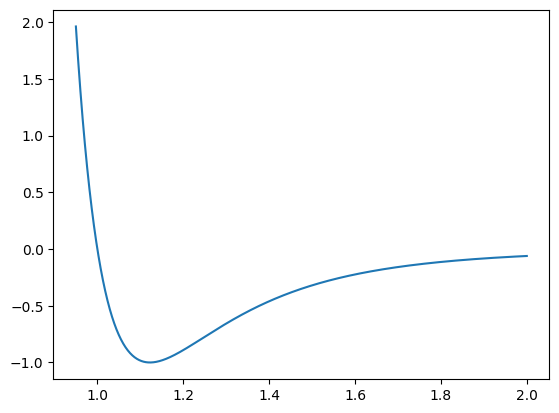

In [82]:
def U_LJ(r_1, epsilon, sigma):
  r = np.array([r_1]*np.size(r_1, axis = 0))
  r = r - np.transpose(r, axes = (1, 0, 2))
  d = np.linalg.norm((r), axis = 2)
  d = np.where(d == 0, np.inf, d)
  U = 4*epsilon*((sigma/d)**12 - (sigma/d)**6)
  return U

def F_LJ(r_1, epsilon, sigma): #dist_table needed
  r = np.array([r_1]*np.size(r_1, axis = 0))
  r = r - np.transpose(r, axes = (1, 0, 2))
  d = np.linalg.norm((r), axis = 2)
  d = np.where(d == 0, 1, d)
  F = 24*epsilon/(d**2)*(2*(sigma/d)**12 - (sigma/d)**6)
  F = np.transpose(np.array([F]*np.size(r_1, axis = 1)), axes = (1, 2, 0))
  F = np.multiply(F, -r)
  return F

d = np.linspace(0.95, 2, 1000)
sigma = 1
epsilon = 1
plt.plot(d, 4*epsilon*((sigma/d)**12 - (sigma/d)**6))


In [83]:
class particle():
    def __init__(self, pos, v):
        self.pos = pos
        self.x = pos[0]
        self.y = pos[1]
        self.z = pos[2]

        self.v = v
        self.vx = v[0]
        self.vy = v[1]
        self.vz = v[2]

class system():
    def __init__(self, N, positions = None, velocities = None, box_size = np.array([1, 1, 1]), eps = 0.05, sigma = 0.05, r_c = 0.04):
        self.particles = np.empty(N, dtype=particle)

        self.N = N
        self.size = box_size
        self.eps = eps
        self.sigma = sigma
        self.r_c = r_c
        self.time = 0

        self.positions = (positions if positions is not None else np.random.rand(N, 3))
        self.positions = self.positions*self.size
        self.velocities = (velocities if velocities is not None else np.random.rand(N, 3))
        self.particles = [particle(self.positions[i], self.velocities[i]) for i in range(N)]

        self.trajectories = self.positions.reshape(1, N, 3)
        self.v_table = self.velocities.reshape(1, N, 3)
        self.timeline = np.array([0])
        self.KE = np.sum([np.linalg.norm(self.velocities[i])**2 for i in range(N)])/2
        self.PE = np.sum(U_LJ(self.positions, eps, sigma))
        self.rms_v = np.sqrt(2*self.KE/N)


    def get_positions(self):
        return np.array([self.particles[i].pos for i in range(self.N)])

    def get_velocities(self):
        return np.array([self.particles[i].v for i in range(self.N)])

    def dist_table(self):
        #account for PBC
        L = self.size
        dist_table = np.array([[np.linalg.norm(L/2 - np.abs(np.abs(self.positions - self.positions[j]) - L/2), axis = 1)] for j in range(self.N)]).reshape(self.N, self.N)
        return dist_table

    def forces(self, eps = None, sigma = None):
        eps = self.eps if eps is None else eps
        sigma = self.sigma if sigma is None else sigma

        forces = F_LJ(self.dist_table(), eps, sigma)
        forces = np.sum(forces, axis = 1)
        return forces

    def min_dist(self):
        return np.min(self.dist_table() + np.linalg.norm(self.size)*np.eye(self.N))

    def update(self, dt):
        #used for the first update only
        self.positions = self.positions + self.velocities*dt
        self.positions = self.positions % self.size #PBC
        self.trajectories = np.append(self.trajectories, self.positions.reshape(1, self.N, 3), axis = 0)
        self.timeline = np.append(self.timeline, self.time + dt)

    def verlet_update(self, dt, adaptive_timestep):
        #used for all other updates
        forces = self.forces()
        if adaptive_timestep:
            dt1 = self.timeline[-1] - self.timeline[-2]
            self.trajectories = np.append(self.trajectories, self.positions.reshape(1, self.N, 3), axis = 0)
            self.positions = (1 + dt/dt1)*self.positions + 0.5*forces*dt*(dt + dt1) - (dt/dt1)*self.trajectories[-2]
            self.v_table = np.append(self.v_table, ((self.positions - self.trajectories[-2])/(dt + dt1)).reshape(1, self.N, 3), axis = 0)
            self.positions = self.positions % self.size #PBC
            self.time += dt
            self.timeline = np.append(self.timeline, self.time)

        else:
            self.trajectories = np.append(self.trajectories, self.positions.reshape(1, self.N, 3), axis = 0)
            self.positions = 2*self.positions - self.trajectories[-2] + forces*(dt**2)
            self.v_table = np.append(self.v_table, ((self.positions - self.trajectories[-1])/(2*dt)).reshape(1, self.N, 3), axis = 0)
            self.positions = self.positions % self.size #PBC
            self.time += dt
            self.timeline = np.append(self.timeline, self.time)

    def run(self, num_steps, adaptive_timestep = True):
        run_time = self.time
        dt = (1/np.cbrt(self.N))/(100*self.rms_v)
        self.update(dt)
        self.trajectories = np.delete(self.trajectories, -1, axis = 0)
        for i in range(num_steps-1):
            if adaptive_timestep:
                dt = self.min_dist()/(100*self.rms_v)
            self.verlet_update(dt=dt, adaptive_timestep=adaptive_timestep)
            run_time += dt
        print("run complete, run time:", run_time)
        self.time = run_time
        return self.trajectories


In [84]:
s = system(100)
s.min_dist(), s.rms_v, s.time, s.v_table

(0.029249293600582496,
 0.9919031663215336,
 0,
 array([[[0.20158447, 0.40557205, 0.62969583],
         [0.25527531, 0.42544752, 0.26988006],
         [0.60583896, 0.60585813, 0.42726305],
         [0.53070733, 0.19632375, 0.87269008],
         [0.90934489, 0.34780745, 0.90935987],
         [0.30585815, 0.50803685, 0.75817509],
         [0.39218517, 0.51724132, 0.1116784 ],
         [0.15317999, 0.92238529, 0.78723833],
         [0.57058713, 0.62391543, 0.09072009],
         [0.48606548, 0.1396919 , 0.11650016],
         [0.0820585 , 0.3395316 , 0.44893247],
         [0.90116791, 0.66249819, 0.68991214],
         [0.35663775, 0.04987052, 0.82095138],
         [0.95132867, 0.03145153, 0.61620309],
         [0.2768807 , 0.06504969, 0.06260645],
         [0.98949704, 0.82352375, 0.26972857],
         [0.19964087, 0.97757048, 0.28951131],
         [0.85046837, 0.73203629, 0.77419717],
         [0.7430708 , 0.63881753, 0.28559492],
         [0.4935817 , 0.30933894, 0.01160336],
         [0.

run complete, run time: 0.36037715555610556


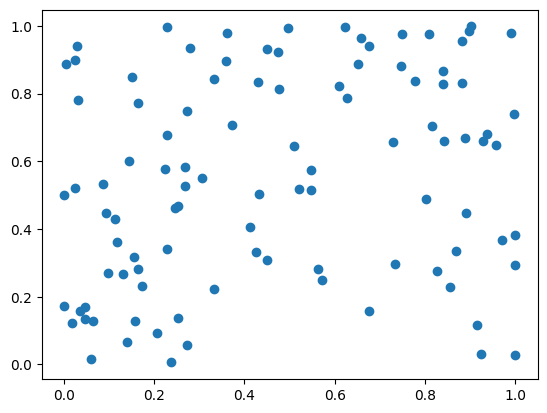

In [86]:
s.run(500)
s.v_table.shape
plt.scatter(s.positions[:, 0], s.positions[:, 1])

In [48]:
s.timeline.shape, s.v_table.shape

((501,), (500, 100, 3))

In [31]:
s.v_table = np.append(s.v_table, ((s.positions - s.trajectories[-1])/0.001).reshape(1, s.N, 3), axis = 0)
s.v_table.shape

(3, 100, 3)

In [87]:
total_p = np.sum(s.v_table, axis = 1)
total_p.shape

(999, 3)

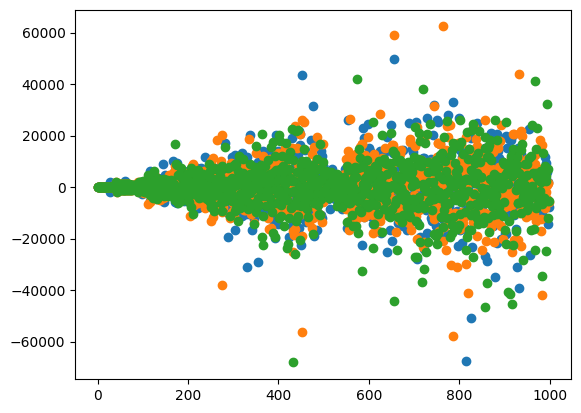

In [88]:
total_p
plt.plot(total_p, 'o')
#plt.ylim(-200,200)


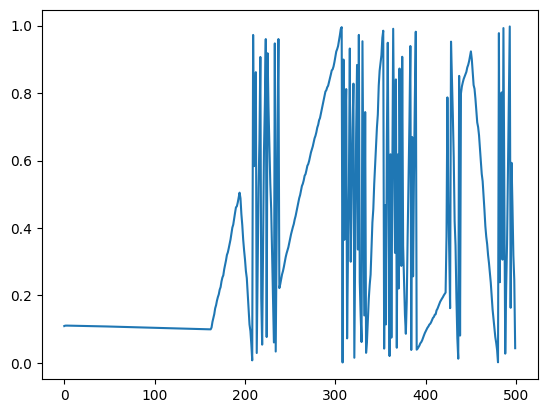

In [61]:
plt.plot(s.trajectories[:, 70, 2])

In [3]:
a = np.array([1, 2, 3])
a[-1], a[-2]

(3, 2)